In [1]:
import numpy as np
import os
import pdb
import evaluate
import librosa
import math
import mir_eval
import IPython.display as ipd
from matplotlib import pyplot as plt
from scipy.signal import medfilt as medfilt
from scipy.misc import electrocardiogram
from scipy import signal
from scipy.ndimage import maximum_filter1d as maxfilt

In [2]:
#odf generators
threshold = np.asarray([[0.1], [0.125], [0.2], [0.25], [0.0], [0.0], [0.0]])
winSize_secs = 0.04
hopSize_secs = 0.01
wd=3
selected_odf = 1

dataDir = './BallroomData'
annotDir = './BallroomAnnotations'
# dataDir = './BallroomAuditor'

# define reasonable limitations
bpm_limits = [61, 200]
tau_limits = []
for bpm in bpm_limits:
    freq = bpm / 60
    tau = round(1 / (freq * hopSize_secs))
    tau_limits.append(tau)

# beat tracking
analysis_fraction = 4 #analyses the first 1/n samples of the song to determine beat 1 location
half_sqr_width = 5
performance_deviation = 4
tempo_dec_tol = .20 #percent
tempo_inc_tol = .10
alpha = 1
final_offset = 0 #postprocessing

if os.path.isdir('beats') == False:
    os.makedirs('beats')

In [3]:
def get_all_odf(filename, winSize_secs, hopSize_secs):
#     print('file is: ', filename)
    snd, rate = librosa.load(filename, sr=None)
    hop = round(rate * hopSize_secs)
    winLen_samps = rate * winSize_secs
    # round up to next power of 2
    wlen_samps = int(2 ** np.ceil(np.log2(winLen_samps)))
#     print('window length is: ', wlen_samps)
#     print('hop length is: ', hop)
    # centre frames: first frame at t=0 - Kind of a hack way of thinking about it
    snd = np.concatenate([np.zeros(wlen_samps//2), snd, np.zeros(wlen_samps//2)])
    # how many frames will cover this sound recording - Do the '- wlen_samps' and  '+1' cancel each other out?
    frameCount = int(np.floor((len(snd) - wlen_samps) / hop + 1))
#     print('Frames per audio file', frameCount)
    #odf is an object that holds 7 types of measurements for onsets
    odf = np.zeros((7, frameCount))
    ham_wind = np.hamming(wlen_samps)
    #preempting prev values needed
    prevM = np.zeros(wlen_samps)
    prevA = np.zeros(wlen_samps)
    prevprevA = np.zeros(wlen_samps)
    # cycle through audio and add each calculation to the appropriate odf frame as you go
    for i in range(frameCount):
        start = i * hop
        # mutiply signal frame by hamming frame and get fft of this
        # remember that the fft consists of a real and imaginary number
        currentFrame = np.fft.fft(snd[start: start+wlen_samps] * ham_wind)
        
        """Root Mean Square"""
        mags = np.abs(currentFrame)
        squared_mags = np.power(mags, 2)
        mean_sqr_mags = np.mean(squared_mags)
        rms = np.sqrt(mean_sqr_mags)
        odf[0][i] = rms
#         print('rms', rms)
        
        """High Freq Content"""
        # Since mags is mirrored after the Nyquist index, multiplying this by a mirrored index and getting its
        # mean will be the same as getting the mean of the first half of the mags 
        k_vector = list(range(wlen_samps//2)) + list(range(wlen_samps//2,0,-1))
        hfc_calc1 = np.mean(np.multiply(squared_mags, k_vector))
        odf[1][i] = hfc_calc1
        
        # hfc while trying to follow the algorithm (especially where k=-N/2)
        weight_vector = np.arange(wlen_samps) - wlen_samps//2
        # half the values cancel the other half out, except for 1, which is left
        left_over = np.sum(np.multiply(weight_vector, squared_mags))
        hfc_calc2 = 4/(wlen_samps*(wlen_samps+2)) * np.sum(np.multiply(weight_vector, squared_mags))
        
        """Spectral FLuz"""       
        sf = np.mean(np.multiply(np.subtract(mags, prevM),np.greater(mags, prevM)))
#         print('sf',sf)
        odf[2][i] = sf
        
        #apply half-wave retifier logic
        h0 = ((mags - prevM) + abs(mags - prevM))/2
        # when h0 element is less than 0, make it zero (using boolean array method)
        H = h0[h0 > 0]
        sf2 = np.sum(H) / wlen_samps
        
        """Complex Domain"""
        
        phase = np.angle(currentFrame)
        tPhase = np.subtract(np.multiply(prevA, 2), prevprevA)
        cdVector = np.sqrt(np.subtract(np.add(np.power(prevM,2), np.power(mags,2)),
                        np.multiply(np.multiply(np.multiply(prevM, mags), 2),
                        # this is the princarg phase wrapping?
                        np.cos(np.subtract(phase, tPhase)))))
        odf[3][i] = np.mean(cdVector)
        rcd = np.mean(np.multiply(np.greater_equal(mags, prevM), cdVector))
        odf[4][i] = rcd
        
        """Phase Deviation"""
        pdVector = np.abs(np.divide(np.subtract(np.mod(np.add(
                        np.subtract(phase, tPhase), np.pi), 2 * np.pi), np.pi), np.pi))
        odf[5][i] = np.mean(pdVector)
        if rms != 0:
            wpd = np.divide(np.mean(np.multiply(pdVector, mags)), rms * 2)
        else:
            wpd=0
        odf[6][i] = wpd
        
        rate_change_phase = phase - prevA
        i_component=(phase + rate_change_phase)
        target_complex_value = mags * np.exp(i_component)
        prevM = mags
        prevA = phase
    return odf

def normalize(arr):
    mx = arr.max(axis=1)
    for i in range(mx.shape[0]):
        if mx[i] > 0:
            arr[i,:] /= mx[i]
    return arr

def process_odf(selected_odf, maxFiltODF, threshold_array):
    # convert odf to a signal that marks the instance and magnitude of the onset only
    caught_odf = threshold_array[selected_odf]
    odf = maxFiltODF[selected_odf]
    threshold_odf = threshold[selected_odf]
    type(threshold_odf), threshold_odf
    caught_odf[caught_odf == threshold_odf[0]] = 0
    # trim threshold values so there only a single peak present every 50ms (Dixon 2001)
    onset_peak_indices, peak_value_dict = signal.find_peaks(caught_odf, height=0, distance=10)
    peak_times = onset_peak_indices * hopSize_secs
    peak_values = peak_value_dict['peak_heights']
    trimmed_odf = np.zeros_like(caught_odf)
    trimmed_odf[onset_peak_indices] = peak_values
    return trimmed_odf, onset_peak_indices

def acfTempo(trimmed_odf, tau_limits):
    # autocorrelate the entire odf signal with itself
    autocor = np.correlate(trimmed_odf, trimmed_odf, mode='full')[int(len(np.correlate(trimmed_odf, trimmed_odf, mode='full'))//2)+1:]
    acf_peak_indices, acf_peak_value_dict = signal.find_peaks(autocor, height=np.max(autocor)/2, distance=5)
    acf_peak_values = acf_peak_value_dict['peak_heights']
    peaked_autocor = np.zeros_like(autocor)
    peaked_autocor[acf_peak_indices] = acf_peak_values
    best_tau_samples = np.argpartition(autocor, -4)[-4:]
    peak_values = autocor[best_tau_samples]
    #most reasonable value is between tau_limits
    for best_tau_sample in best_tau_samples:
        if best_tau_sample > tau_limits[1] and best_tau_sample < tau_limits[0]:
            tactus_tau = best_tau_sample
        else:
            tactus_tau = np.min(best_tau_samples)
    #  add 1 to tactus_tau (due to 0 indexing) to get the true sample delay
    tactus_tau = tactus_tau + 1
    return tactus_tau

def beatTimes_to_array(trueOnsets, trimmed_odf):
    trueOnsets_resampled = trueOnsets * 100
    trueOnsets_beats = np.zeros_like(trimmed_odf)
    for beat_time in trueOnsets_resampled:
        beat_time = int(beat_time)
        trueOnsets_beats[beat_time] = 1
    return trueOnsets_beats

def find_first_beat(trimmed_odf, tactus_tau, onset_peak_indices):
    # make a pulse train
    window_length = len(trimmed_odf)//analysis_fraction
    # THIS GIVES YOU A VISUALISATION OF HOW THEY MATCH UP
    # Larcohe 2003, Alonos 2004
    # -5 to 5 used to represent precentage that tempo can vary in either direction
    sqr_pulse = np.zeros_like(trimmed_odf)
    for i in range(len(trimmed_odf)//tactus_tau):
        index = i * tactus_tau
        for i in range(-half_sqr_width,half_sqr_width):
            sqr_pulse[index+i] = 1

    correlation_at_onsets = []
    # assume the first 10 onsets - one of them is the downbeat
    initial_onsets_to_analyse = 10
    # just empircally testing to scan first 6 onsets and choose the best one that will tell me where the first onset is
    for onset_peak_index in onset_peak_indices[:initial_onsets_to_analyse]:
        trimmed_odf_window = trimmed_odf[onset_peak_index : onset_peak_index+window_length]
        if len(trimmed_odf_window) < window_length:
            break
        pulse_window = sqr_pulse[:window_length]
        summed_sigs = np.sum(trimmed_odf_window * pulse_window)
        correlation_at_onsets.append(summed_sigs)
    # plt.plot(correlation_at_onsets)
    onset_peak_index = np.where(np.asarray(correlation_at_onsets) == np.max(np.asarray(correlation_at_onsets)))[0][0]
    first_beat_index = onset_peak_indices[onset_peak_index]
    return first_beat_index

def find_beats(trimmed_odf, tactus_tau, first_beat_index):
    beat_indices = [first_beat_index]

    tactus_dec_tol = round(tactus_tau * tempo_dec_tol) #tempo increase means increasing tau value
    tactus_inc_tol = round(tactus_tau * tempo_inc_tol) #tempo increase means decreasing tau value
    outside_perf_region = 0
    missing_onsets = 0
    within_tempo_region = 0

    while beat_indices[-1] < len(trimmed_odf)-tactus_tau:
        next_beat_pred = beat_indices[-1] + tactus_tau
    #     print('next_beat_pred',next_beat_pred)
        performance_region = trimmed_odf[next_beat_pred - performance_deviation: next_beat_pred + performance_deviation+1]
        onset_locations = np.where(performance_region != 0)[0]
        if len(onset_locations)>0:
            missing_onsets = 0
            # find out which location is closer to 5
            closest_to_centre = performance_deviation + 2
            for onset in onset_locations:
                if abs(onset - performance_deviation) < closest_to_centre:
                    closest_index = onset
                    closest_to_centre = abs(onset - performance_deviation)
            offset = closest_index - performance_deviation
            adjusted_beat_pred = next_beat_pred + offset
        else:
            # check the window tollerance for tempo change
            tempo_change_region = trimmed_odf[next_beat_pred - tactus_inc_tol: next_beat_pred + tactus_dec_tol+1] 
            onset_locations = np.where(tempo_change_region != 0)[0]
            if len(onset_locations)>0:
                missing_onsets = 0
                closest_to_centre = tactus_dec_tol + 2 # just to start off
                for onset in onset_locations:
                    centered_index = tactus_dec_tol-tactus_inc_tol
                    if abs(centered_index - onset) < closest_to_centre:
                        closest_index = onset
                        closest_to_centre = abs(centered_index-onset)
    #             pdb.set_trace()
                offset = closest_index - centered_index
                adjusted_beat_pred = next_beat_pred + offset
                tactus_tau = round((alpha*(tactus_tau + offset)) + ((1 - alpha)*tactus_tau))
            else:
                # assign a beat to default place
                missing_onsets += 1
                adjusted_beat_pred = next_beat_pred
    #     print('adjusted_beat_pred',adjusted_beat_pred)
        beat_indices.append(adjusted_beat_pred)


    # if last onsets were missed, remove them
    beat_indices = beat_indices[:len(beat_indices)-missing_onsets]

    missing_onsets = 0
    no_more_anacrusis = False
    while beat_indices[0] - tactus_tau > 0 and no_more_anacrusis == False:
    #     pdb.set_trace()
        previous_beat_pred = beat_indices[0] - tactus_tau
        anacrusis_region = trimmed_odf[previous_beat_pred-performance_deviation: previous_beat_pred+performance_deviation]
        onset_locations = np.where(anacrusis_region != 0)[0]
        if len(onset_locations)>0:
            # find out which location is closer to 5
            closest_to_centre = performance_deviation + 2
            for onset in onset_locations:
                if abs(onset - performance_deviation) < closest_to_centre:
                    closest_index = onset
                    closest_to_centre = abs(onset - performance_deviation)
            offset = closest_index-performance_deviation
    #         pdb.set_trace()
            adjusted_beat_pred = previous_beat_pred + offset
            beat_indices.insert(0, adjusted_beat_pred)
        else:
            no_more_anacrusis = True
    beat_indices = beat_indices[missing_onsets:]
    return beat_indices

In [4]:
f_scores = np.empty((0))
p_scores = np.empty((0))
continuities = np.empty((0))
info_gains = np.empty((0))
counter= 0
for i, d in enumerate(os.scandir(dataDir)):
    if not os.path.isdir(d.path):
        print('Found non-dir in dirs: ', d.name)
    else:
        for j, f in enumerate(os.scandir(d.path)):
            if f.name[-4:] == '.wav':
                f_annot_path = os.path.join(annotDir, f.name[:-4] + '.beats')
                if os.path.exists(f_annot_path):
                    counter += 1
                    trueOnsets = np.reshape(np.fromfile(f_annot_path, sep = '\n'), (-1, 2))[:,0]
                    f_path = f.path
                    odf = get_all_odf(f_path, winSize_secs, hopSize_secs)
                    t = np.arange(odf.shape[1]) * hopSize_secs
                    # smoothen it out
                    medFiltODF = odf - medfilt(odf, wd)
                    for row in medFiltODF:
                        maxFiltEntry = maxfilt(medFiltODF, wd, mode='nearest', axis=0)
                        try:
                            np.concatenate((maxFiltODF, maxFiltEntry), axis=0)
                        except:
                            maxFiltODF = maxFiltEntry
                    maxFiltODF = maxfilt(medFiltODF, wd, mode='nearest', axis=1)
                    maxFiltODF = np.gradient(maxFiltODF, axis=1)
                    maxFiltODF = np.divide(np.subtract(maxFiltODF, np.mean(maxFiltODF)), np.std(maxFiltODF))
                    maxFiltODF = normalize(maxFiltODF)
                    # removing any artefacts causing false positives at the very start or end - this would not interefere with any beates
                    maxFiltODF[:,:3] = maxFiltODF[:,3000:] = 0
                    threshold_array = np.ones(maxFiltODF.shape) * threshold
                    for row_idx in range(len(maxFiltODF)):
                        for col_idx in range(len(maxFiltODF[row_idx])):
                            threshold_array[row_idx][col_idx] = max(maxFiltODF[row_idx][col_idx], threshold[row_idx])
                    peakTimesODF = []
                    for row_idx in range(len(maxFiltODF)):
                        peaksIndices = np.where(np.greater_equal(maxFiltODF[row_idx], threshold_array[row_idx]))[0] * hopSize_secs
                        peakTimesODF.append(peaksIndices)
                #     peakIndices = np.nonzero(np.greater_equal(maxFiltODF, threshold_array))
                    audio, sr = librosa.load(f_path, sr=None)
                    deciRate = sr * hopSize_secs
                    # PROCESS ODF
                    trimmed_odf, onset_peak_indices = process_odf(selected_odf, maxFiltODF, threshold_array)
                    # AUTOCORRELATION TO DETERMINE TEMPO
                    tactus_tau = acfTempo(trimmed_odf, tau_limits)
                    onset_beat_times = beatTimes_to_array(trueOnsets, trimmed_odf)
                    first_beat_index = find_first_beat(trimmed_odf, tactus_tau, onset_peak_indices)
                    beat_indices = find_beats(trimmed_odf, tactus_tau, first_beat_index)
                    beat_indices = np.asarray(beat_indices) - final_offset
                    beat_times = beat_indices * hopSize_secs
                    np.savetxt('beats/' +f.name[:-4] +'.csv', beat_times, delimiter=",")
                    f_score = mir_eval.beat.f_measure(trueOnsets, beat_times)
                    f_scores = np.append(f_scores, f_score)
                    p_score = mir_eval.beat.p_score(trueOnsets, beat_times)
                    p_scores = np.append(p_scores, p_score)
                    continuity = mir_eval.beat.continuity(trueOnsets, beat_times)
                    continuities = np.append(continuities, continuity)
                    info_gain = mir_eval.beat.information_gain(trueOnsets, beat_times, bins=41)
                    info_gains = np.append(info_gains, info_gain)
                    print(f'{counter} {f_annot_path}, f: {f_score:.2f}, p: {p_score:.2f}, ig: {info_gain:.2f}, c: {continuity[0]:.2f} {continuity[1]:.2f} {continuity[2]:.2f} {continuity[3]:.2f}')

print()
print('Total Average Scores Across Dataset')
print(f'f: {np.mean(f_scores):.2f}, p: {np.mean(p_scores):.2f}, ig: {np.mean(info_gains):.2f}, cont: {np.mean(continuities)}')

1 ./BallroomAnnotations/Media-105901.beats, f: 0.27, p: 0.43, ig: 0.04, c: 0.00 0.00 0.00 0.00
2 ./BallroomAnnotations/Albums-Step_By_Step-04.beats, f: 0.08, p: 0.09, ig: 0.13, c: 0.00 0.00 0.18 0.18
3 ./BallroomAnnotations/Media-104202.beats, f: 0.33, p: 0.43, ig: 0.03, c: 0.00 0.00 0.00 0.00
4 ./BallroomAnnotations/Media-104203.beats, f: 0.85, p: 0.77, ig: 0.48, c: 0.77 0.77 0.77 0.77
5 ./BallroomAnnotations/Media-105902.beats, f: 0.27, p: 0.42, ig: 0.13, c: 0.00 0.00 0.07 0.09
6 ./BallroomAnnotations/Media-104201.beats, f: 0.20, p: 0.11, ig: 0.32, c: 0.00 0.00 0.00 0.00
7 ./BallroomAnnotations/Media-104604.beats, f: 0.22, p: 0.30, ig: 0.10, c: 0.09 0.09 0.09 0.14
8 ./BallroomAnnotations/Albums-Step_By_Step-02.beats, f: 0.09, p: 0.07, ig: 0.11, c: 0.00 0.00 0.00 0.00
9 ./BallroomAnnotations/Media-104402.beats, f: 0.31, p: 0.40, ig: 0.05, c: 0.00 0.00 0.00 0.00
10 ./BallroomAnnotations/Media-104204.beats, f: 0.04, p: 0.02, ig: 0.10, c: 0.00 0.00 0.00 0.00
11 ./BallroomAnnotations/Medi

84 ./BallroomAnnotations/Media-104801.beats, f: 0.28, p: 0.41, ig: 0.03, c: 0.00 0.00 0.00 0.00
85 ./BallroomAnnotations/Media-104803.beats, f: 0.45, p: 0.44, ig: 0.23, c: 0.07 0.08 0.39 0.39
86 ./BallroomAnnotations/Albums-Chrisanne1-03.beats, f: 0.05, p: 0.02, ig: 0.10, c: 0.00 0.00 0.00 0.00
87 ./BallroomAnnotations/Media-105704.beats, f: 0.18, p: 0.21, ig: 0.12, c: 0.10 0.12 0.17 0.20
88 ./BallroomAnnotations/Media-105102.beats, f: 0.31, p: 0.40, ig: 0.02, c: 0.00 0.00 0.00 0.00
89 ./BallroomAnnotations/Media-105301.beats, f: 0.21, p: 0.43, ig: 0.11, c: 0.00 0.00 0.13 0.23
90 ./BallroomAnnotations/Media-105103.beats, f: 0.41, p: 0.43, ig: 0.18, c: 0.00 0.00 0.43 0.51
91 ./BallroomAnnotations/Albums-Chrisanne1-02.beats, f: 0.25, p: 0.34, ig: 0.02, c: 0.00 0.00 0.00 0.00
92 ./BallroomAnnotations/Media-104802.beats, f: 0.31, p: 0.42, ig: 0.03, c: 0.00 0.00 0.00 0.00
93 ./BallroomAnnotations/Albums-Secret_Garden-02.beats, f: 0.30, p: 0.43, ig: 0.04, c: 0.00 0.00 0.00 0.00
94 ./Ballroom

166 ./BallroomAnnotations/Albums-Chrisanne1-07.beats, f: 0.34, p: 0.22, ig: 0.07, c: 0.00 0.00 0.24 0.33
167 ./BallroomAnnotations/Media-104608.beats, f: 0.02, p: 0.01, ig: 0.06, c: 0.00 0.00 0.00 0.00
168 ./BallroomAnnotations/Media-104811.beats, f: 0.52, p: 0.45, ig: 0.03, c: 0.00 0.00 0.03 0.25
169 ./BallroomAnnotations/Media-104408.beats, f: 0.55, p: 0.46, ig: 0.18, c: 0.27 0.28 0.27 0.28
170 ./BallroomAnnotations/Media-105110.beats, f: 0.07, p: 0.04, ig: 0.08, c: 0.00 0.00 0.00 0.00
171 ./BallroomAnnotations/Media-105307.beats, f: 0.23, p: 0.17, ig: 0.04, c: 0.01 0.01 0.05 0.09
172 ./BallroomAnnotations/Media-105111.beats, f: 0.11, p: 0.07, ig: 0.09, c: 0.00 0.00 0.00 0.00
173 ./BallroomAnnotations/Albums-Step_By_Step-09.beats, f: 0.28, p: 0.21, ig: 0.07, c: 0.00 0.00 0.18 0.25
174 ./BallroomAnnotations/Media-104409.beats, f: 0.18, p: 0.12, ig: 0.07, c: 0.00 0.00 0.16 0.16
175 ./BallroomAnnotations/Media-104810.beats, f: 0.55, p: 0.46, ig: 0.02, c: 0.00 0.00 0.11 0.35
Found non-di

248 ./BallroomAnnotations/Albums-Macumba-02.beats, f: 0.62, p: 0.45, ig: 0.67, c: 0.00 0.00 0.90 0.90
249 ./BallroomAnnotations/Media-105601.beats, f: 0.88, p: 0.79, ig: 0.59, c: 0.79 0.79 0.79 0.79
250 ./BallroomAnnotations/Media-105417.beats, f: 0.68, p: 0.68, ig: 0.51, c: 0.68 0.68 0.68 0.68
251 ./BallroomAnnotations/Albums-Latin_Jam5-11.beats, f: 0.39, p: 0.25, ig: 0.61, c: 0.00 0.00 0.00 0.00
252 ./BallroomAnnotations/Media-103701.beats, f: 0.31, p: 0.25, ig: 0.36, c: 0.00 0.00 0.16 0.16
253 ./BallroomAnnotations/Albums-Macumba-03.beats, f: 0.62, p: 0.47, ig: 0.68, c: 0.00 0.00 0.93 0.93
254 ./BallroomAnnotations/Albums-Mambo_Kings-11.beats, f: 0.59, p: 0.49, ig: 0.41, c: 0.00 0.00 0.74 0.75
255 ./BallroomAnnotations/Media-103410.beats, f: 0.64, p: 0.50, ig: 0.52, c: 0.00 0.00 0.79 0.90
256 ./BallroomAnnotations/Albums-Latin_Jam3-03.beats, f: 0.24, p: 0.18, ig: 0.31, c: 0.00 0.00 0.03 0.03
257 ./BallroomAnnotations/Media-103404.beats, f: 0.97, p: 0.94, ig: 0.65, c: 0.94 0.94 0.94 

330 ./BallroomAnnotations/Media-103918.beats, f: 0.95, p: 0.90, ig: 0.57, c: 0.90 0.90 0.90 0.90
331 ./BallroomAnnotations/Media-105414.beats, f: 0.52, p: 0.38, ig: 0.31, c: 0.00 0.00 0.56 0.56
332 ./BallroomAnnotations/Media-105415.beats, f: 0.27, p: 0.15, ig: 0.38, c: 0.00 0.00 0.00 0.00
333 ./BallroomAnnotations/Media-103919.beats, f: 0.60, p: 0.44, ig: 0.68, c: 0.00 0.00 0.89 0.89
334 ./BallroomAnnotations/Albums-Macumba-14.beats, f: 0.22, p: 0.14, ig: 0.08, c: 0.00 0.00 0.00 0.00
335 ./BallroomAnnotations/Albums-Latin_Jam-11.beats, f: 0.28, p: 0.17, ig: 0.14, c: 0.00 0.00 0.02 0.02
336 ./BallroomAnnotations/Media-104119.beats, f: 0.63, p: 0.47, ig: 0.60, c: 0.00 0.00 0.95 0.95
337 ./BallroomAnnotations/Albums-Macumba-16.beats, f: 0.36, p: 0.22, ig: 0.50, c: 0.00 0.00 0.00 0.00
338 ./BallroomAnnotations/Media-103516.beats, f: 0.24, p: 0.20, ig: 0.18, c: 0.02 0.02 0.11 0.12
339 ./BallroomAnnotations/Albums-Latin_Jam5-04.beats, f: 0.64, p: 0.47, ig: 0.67, c: 0.00 0.00 0.95 0.95
340 .

410 ./BallroomAnnotations/Media-104906.beats, f: 0.38, p: 0.39, ig: 0.02, c: 0.00 0.00 0.00 0.00
411 ./BallroomAnnotations/Media-104709.beats, f: 0.31, p: 0.25, ig: 0.10, c: 0.06 0.06 0.06 0.06
412 ./BallroomAnnotations/Albums-StrictlyDancing_Tango-11.beats, f: 0.15, p: 0.10, ig: 0.24, c: 0.00 0.00 0.10 0.10
413 ./BallroomAnnotations/Albums-StrictlyDancing_Tango-05.beats, f: 0.14, p: 0.10, ig: 0.07, c: 0.00 0.00 0.00 0.00
414 ./BallroomAnnotations/Albums-StrictlyDancing_Tango-04.beats, f: 0.40, p: 0.31, ig: 0.22, c: 0.00 0.00 0.50 0.50
415 ./BallroomAnnotations/Albums-StrictlyDancing_Tango-10.beats, f: 0.12, p: 0.07, ig: 0.09, c: 0.00 0.00 0.00 0.00
416 ./BallroomAnnotations/Media-104708.beats, f: 0.37, p: 0.41, ig: 0.07, c: 0.00 0.00 0.03 0.22
417 ./BallroomAnnotations/Media-104907.beats, f: 0.43, p: 0.48, ig: 0.13, c: 0.00 0.00 0.27 0.35
418 ./BallroomAnnotations/Media-103305.beats, f: 0.53, p: 0.38, ig: 0.30, c: 0.00 0.00 0.72 0.72
419 ./BallroomAnnotations/Albums-Ballroom_Magic-07.

492 ./BallroomAnnotations/Media-105607.beats, f: 0.58, p: 0.45, ig: 0.57, c: 0.00 0.00 0.92 0.92
493 ./BallroomAnnotations/Media-103504.beats, f: 0.10, p: 0.10, ig: 0.15, c: 0.00 0.00 0.30 0.30
494 ./BallroomAnnotations/Albums-Fire-09.beats, f: 0.37, p: 0.23, ig: 0.57, c: 0.00 0.00 0.00 0.00
495 ./BallroomAnnotations/Media-106118.beats, f: 0.58, p: 0.50, ig: 0.50, c: 0.00 0.00 0.71 0.71
496 ./BallroomAnnotations/Media-103706.beats, f: 0.31, p: 0.38, ig: 0.19, c: 0.19 0.23 0.19 0.23
497 ./BallroomAnnotations/Media-103707.beats, f: 0.37, p: 0.22, ig: 0.49, c: 0.00 0.00 0.00 0.00
498 ./BallroomAnnotations/Media-105404.beats, f: 0.75, p: 0.60, ig: 0.57, c: 0.60 0.60 0.60 0.60
499 ./BallroomAnnotations/Media-103505.beats, f: 0.38, p: 0.26, ig: 0.19, c: 0.00 0.00 0.44 0.44
500 ./BallroomAnnotations/Albums-Macumba-05.beats, f: 0.49, p: 0.36, ig: 0.42, c: 0.00 0.00 0.91 0.91
501 ./BallroomAnnotations/Media-105606.beats, f: 0.88, p: 0.78, ig: 0.57, c: 0.78 0.78 0.78 0.78
502 ./BallroomAnnotatio

575 ./BallroomAnnotations/Media-104916.beats, f: 0.16, p: 0.09, ig: 0.12, c: 0.00 0.00 0.00 0.00
576 ./BallroomAnnotations/Media-105017.beats, f: 0.35, p: 0.23, ig: 0.09, c: 0.00 0.00 0.27 0.37
577 ./BallroomAnnotations/Media-103314.beats, f: 0.59, p: 0.42, ig: 0.50, c: 0.00 0.00 0.84 0.84
578 ./BallroomAnnotations/Albums-Ballroom_Magic-16.beats, f: 0.13, p: 0.08, ig: 0.04, c: 0.00 0.00 0.18 0.22
579 ./BallroomAnnotations/Media-105820.beats, f: 0.40, p: 0.24, ig: 0.13, c: 0.00 0.00 0.39 0.39
580 ./BallroomAnnotations/Media-104915.beats, f: 0.27, p: 0.25, ig: 0.11, c: 0.01 0.01 0.15 0.17
581 ./BallroomAnnotations/Albums-Ballroom_Magic-15.beats, f: 0.60, p: 0.43, ig: 0.45, c: 0.00 0.00 0.87 0.87
582 ./BallroomAnnotations/Media-103313.beats, f: 0.47, p: 0.39, ig: 0.08, c: 0.25 0.25 0.25 0.25
583 ./BallroomAnnotations/Media-105819.beats, f: 0.20, p: 0.11, ig: 0.33, c: 0.00 0.00 0.00 0.00
584 ./BallroomAnnotations/Media-105818.beats, f: 0.46, p: 0.30, ig: 0.19, c: 0.00 0.00 0.59 0.59
585 ./

/Users/brendanoconnor/Desktop/MI/venvMI/lib/python3.8/site-packages/mir_eval/beat.py:376: UserWarning: Only one estimated beat was provided, so beat intervals cannot be computed.
  warnings.warn("Only one estimated beat was provided, so beat intervals"
/Users/brendanoconnor/Desktop/MI/venvMI/lib/python3.8/site-packages/mir_eval/beat.py:464: UserWarning: Only one estimated beat was provided, so beat intervals cannot be computed.
  warnings.warn("Only one estimated beat was provided, so beat intervals"
/Users/brendanoconnor/Desktop/MI/venvMI/lib/python3.8/site-packages/mir_eval/beat.py:622: UserWarning: Only one estimated beat was provided, so beat intervals cannot be computed.
  warnings.warn("Only one estimated beat was provided, so beat intervals"


655 ./BallroomAnnotations/Albums-AnaBelen_Veneo-15.beats, f: 0.00, p: 0.00, ig: 0.00, c: 0.00 0.00 0.00 0.00
656 ./BallroomAnnotations/Albums-AnaBelen_Veneo-01.beats, f: 0.36, p: 0.42, ig: 0.05, c: 0.00 0.00 0.00 0.00
657 ./BallroomAnnotations/Albums-Latin_Jam3-08.beats, f: 0.41, p: 0.27, ig: 0.41, c: 0.00 0.00 0.00 0.00
658 ./BallroomAnnotations/Albums-Pais_Tropical-11.beats, f: 0.24, p: 0.38, ig: 0.10, c: 0.00 0.00 0.05 0.05
659 ./BallroomAnnotations/Albums-Pais_Tropical-10.beats, f: 0.00, p: 0.00, ig: 0.21, c: 0.00 0.00 0.00 0.00
660 ./BallroomAnnotations/Albums-Pais_Tropical-12.beats, f: 0.26, p: 0.38, ig: 0.13, c: 0.02 0.02 0.08 0.09
661 ./BallroomAnnotations/Albums-Latin_Jam4-13.beats, f: 0.91, p: 0.90, ig: 0.66, c: 0.67 0.88 0.67 0.88
662 ./BallroomAnnotations/Albums-Fire-03.beats, f: 0.38, p: 0.23, ig: 0.56, c: 0.00 0.00 0.00 0.00
663 ./BallroomAnnotations/Albums-Latin_Jam2-15.beats, f: 0.97, p: 0.94, ig: 0.92, c: 0.94 0.94 0.94 0.94
664 ./BallroomAnnotations/Media-106112.beats

(array([36., 35., 45., 37., 49., 75., 73., 61., 32., 35., 34., 29., 75.,
        18.,  3.,  5.,  5., 10., 10., 31.]),
 array([0.        , 0.04904459, 0.09808917, 0.14713376, 0.19617834,
        0.24522293, 0.29426752, 0.3433121 , 0.39235669, 0.44140127,
        0.49044586, 0.53949045, 0.58853503, 0.63757962, 0.6866242 ,
        0.73566879, 0.78471338, 0.83375796, 0.88280255, 0.93184713,
        0.98089172]),
 <BarContainer object of 20 artists>)

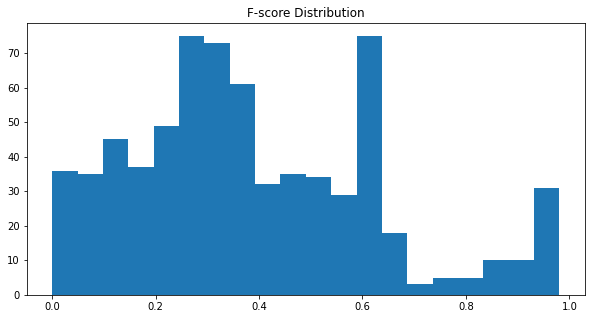

In [10]:
plt.figure(figsize=(10,5))
plt.title('F-score Distribution')
plt.hist(f_scores, bins=20)

(array([ 43.,  48.,  46.,  60.,  65.,  52.,  47.,  42.,  87., 110.,  23.,
          6.,   7.,   5.,   6.,   5.,   8.,   5.,  16.,  17.]),
 array([0.      , 0.048125, 0.09625 , 0.144375, 0.1925  , 0.240625,
        0.28875 , 0.336875, 0.385   , 0.433125, 0.48125 , 0.529375,
        0.5775  , 0.625625, 0.67375 , 0.721875, 0.77    , 0.818125,
        0.86625 , 0.914375, 0.9625  ]),
 <BarContainer object of 20 artists>)

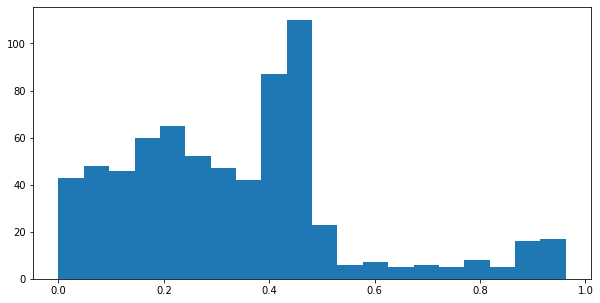

In [8]:
plt.figure(figsize=(10,5))
plt.hist(p_scores, bins=20)

(array([ 76., 130., 101.,  62.,  36.,  27.,  27.,  23.,  22.,  20.,  33.,
         36.,  28.,  39.,  17.,  10.,   5.,   1.,   3.,   2.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

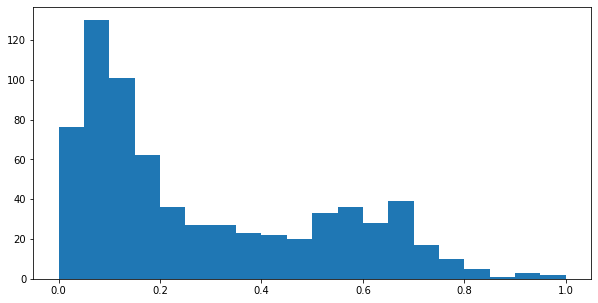

In [9]:
plt.figure(figsize=(10,5))
plt.hist(info_gains, bins=20)